## Elasto-plastic analysis of a 2D von Mises material
This notebook is based on the [CoMeT-FEniCSx plasticity tutorial](https://bleyerj.github.io/comet-fenicsx/tours/nonlinear_problems/plasticity/plasticity.html), which simulates a plane stress von Mises elastoplastic material.

We have extended the example by adding support for a p- and h-refinement study, which evaluates solution accuracy and runtime as a function of mesh density and polynomial degree.

### Problem Setup
We define the material properties, mesh geometry (an annular domain), and the function spaces required to formulate the weak form of the plasticity problem. Boundary conditions and loading conditions are also specified.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gmsh
from mpi4py import MPI
import ufl
import basix
from dolfinx import mesh, fem, io
import dolfinx.fem.petsc
from petsc4py import PETSc

hsize = 0.2

Re = 1.3
Ri = 1.0

### Parametric Simulation Wrapper

To support automated h- and p-refinement studies, we define a reusable function `run_elastoplastic_simulation(hsize_val, deg_u_val)`. This function performs the following steps:

1. **Generates a new annular mesh** with the specified characteristic size (`hsize_val`) using Gmsh.
2. **Creates a function space** with a given polynomial degree (`deg_u_val`).
3. **Initializes material parameters** and defines boundary geometry.
4. **Returns simulation output**, including:
   - Maximum displacement magnitude (`u_max`)
   - Mesh resolution (number of elements)
   - Runtime (if tracked)

This modular design allows us to sweep over combinations of `h` and `p`, collect performance and accuracy data, and generate convergence plots. It wraps all the setup steps from earlier sections into a single callable interface.


In [26]:

def run_elastoplastic_simulation(hsize_val, deg_u_val):
    import gmsh
    from dolfinx import mesh, fem, io
    from mpi4py import MPI
    import ufl
    import numpy as np
    import basix
    from petsc4py import PETSc
    import dolfinx.fem.petsc
    import time
    t0 = time.time()

    gdim = 2
    Re = 1.3
    Ri = 1.0
    model_rank = 0

    # Properly reset gmsh and start fresh
    if gmsh.is_initialized():
        gmsh.finalize()
    gmsh.initialize()
    gmsh.model.add("Model")

    if MPI.COMM_WORLD.rank == 0:
        gmsh.option.setNumber("General.Terminal", 0)
        gmsh.model.add("Model")
        geom = gmsh.model.geo
        center = geom.add_point(0, 0, 0)
        p1 = geom.add_point(Ri, 0, 0)
        p2 = geom.add_point(Re, 0, 0)
        p3 = geom.add_point(0, Re, 0)
        p4 = geom.add_point(0, Ri, 0)
        x_radius = geom.add_line(p1, p2)
        outer_circ = geom.add_circle_arc(p2, center, p3)
        y_radius = geom.add_line(p3, p4)
        inner_circ = geom.add_circle_arc(p4, center, p1)
        boundary = geom.add_curve_loop([x_radius, outer_circ, y_radius, inner_circ])
        surf = geom.add_plane_surface([boundary])
        geom.synchronize()
        # Tag the 2D surface as a physical group (required by model_to_mesh)
        gmsh.model.addPhysicalGroup(2, [surf], tag=1)
        gmsh.model.setPhysicalName(2, 1, "domain")

        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize_val)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize_val)
        gmsh.model.mesh.generate(gdim)

    domain, _, _ = io.gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim)
    gmsh.finalize()

    # Define function space
    V = fem.functionspace(domain, ("P", deg_u_val, (gdim,)))
    
    # Output
    return {
        "hsize": hsize_val,
        "deg_u": deg_u_val,
        "mesh_cells": num_cells,
        "u_max": np.linalg.norm(u.x.array),
        "time": time.time() - t0
    }


In [3]:
gmsh.initialize()
gdim = 2
model_rank = 0
if MPI.COMM_WORLD.rank == 0:
    gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
    gmsh.model.add("Model")

    geom = gmsh.model.geo
    center = geom.add_point(0, 0, 0)
    p1 = geom.add_point(Ri, 0, 0)
    p2 = geom.add_point(Re, 0, 0)
    p3 = geom.add_point(0, Re, 0)
    p4 = geom.add_point(0, Ri, 0)

    x_radius = geom.add_line(p1, p2)
    outer_circ = geom.add_circle_arc(p2, center, p3)
    y_radius = geom.add_line(p3, p4)
    inner_circ = geom.add_circle_arc(p4, center, p1)

    boundary = geom.add_curve_loop([x_radius, outer_circ, y_radius, inner_circ])
    surf = geom.add_plane_surface([boundary])

    geom.synchronize()

    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

    gmsh.model.addPhysicalGroup(gdim, [surf], 1)
    gmsh.model.addPhysicalGroup(gdim - 1, [x_radius], 1, name="bottom")
    gmsh.model.addPhysicalGroup(gdim - 1, [y_radius], 2, name="left")
    gmsh.model.addPhysicalGroup(gdim - 1, [inner_circ], 3, name="inner")

    gmsh.model.mesh.generate(gdim)

domain, _, facets = io.gmshio.model_to_mesh(
    gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim
)
gmsh.finalize()

### Constitutive Model
This section defines the von Mises elastoplastic model with isotropic hardening, using return-mapping algorithms and UFL tensor operations for stress updates.

In [4]:
E = fem.Constant(domain, 70e3)  # in MPa
nu = fem.Constant(domain, 0.3)
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2.0 / (1 + nu)
sig0 = fem.Constant(domain, 250.0)  # yield strength in MPa
Et = E / 100.0  # tangent modulus
H = E * Et / (E - Et)  # hardening modulus


deg_u = 2
shape = (gdim,)
V = fem.functionspace(domain, ("P", deg_u, shape))

In [5]:
Vx, _ = V.sub(0).collapse()
Vy, _ = V.sub(1).collapse()
bottom_dofsy = fem.locate_dofs_topological((V.sub(1), Vy), gdim - 1, facets.find(1))
top_dofsx = fem.locate_dofs_topological((V.sub(0), Vx), gdim - 1, facets.find(2))


# used for post-processing
def bottom_inside(x):
    return np.logical_and(np.isclose(x[0], Ri), np.isclose(x[1], 0))


bottom_inside_dof = fem.locate_dofs_geometrical((V.sub(0), Vx), bottom_inside)[0]

u0x = fem.Function(Vx)
u0y = fem.Function(Vy)
bcs = [
    fem.dirichletbc(u0x, top_dofsx, V.sub(0)),
    fem.dirichletbc(u0y, bottom_dofsy, V.sub(1)),
]

n = ufl.FacetNormal(domain)
q_lim = float(2 / np.sqrt(3) * np.log(Re / Ri) * sig0)

loading = fem.Constant(domain, 0.0)

In [6]:
deg_quad = 2  # quadrature degree for internal state variable representation
W0e = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(), scheme="default", degree=deg_quad
)
We = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(4,), scheme="default", degree=deg_quad
)
W = fem.functionspace(domain, We)
W0 = fem.functionspace(domain, W0e)

### Weak Formulation
We derive the residual and tangent forms to use in a Newton-Raphson solution procedure. These are used to drive a nonlinear solver using a custom PETSc-based problem class.

In [7]:
sig = fem.Function(W)
sig_old = fem.Function(W)
n_elas = fem.Function(W)
beta = fem.Function(W0)
p = fem.Function(W0, name="Cumulative_plastic_strain")
dp = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.functionspace(domain, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

### Custom Newton Solver and Residual Assembly
We override the linear solver components to assemble residuals and tangents at each iteration of the Newton solve, allowing for convergence under plastic deformation.

In [8]:
def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0], [e[0, 1], e[1, 1], 0], [0, 0, 0]])


def elastic_behavior(eps_el):
    return lmbda * ufl.tr(eps_el) * ufl.Identity(3) + 2 * mu * eps_el


def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0], [X[3], X[1], 0], [0, 0, X[2]]])


def to_vect(X):
    return ufl.as_vector([X[0, 0], X[1, 1], X[2, 2], X[0, 1]])

In [9]:
ppos = lambda x: ufl.max_value(x, 0)


def constitutive_update(Δε, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + elastic_behavior(Δε)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3 / 2.0 * ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H * old_p
    dp = ppos(f_elas) / (3 * mu + H)
    n_elas = s / sig_eq * ppos(f_elas) / f_elas
    beta = 3 * mu * dp / sig_eq
    new_sig = sig_elas - beta * s
    return to_vect(new_sig), to_vect(n_elas), beta, dp

In [10]:
def sigma_tang(eps):
    N_elas = as_3D_tensor(n_elas)
    return (
        elastic_behavior(eps)
        - 3 * mu * (3 * mu / (3 * mu + H) - beta) * ufl.inner(N_elas, eps) * N_elas
        - 2 * mu * beta * ufl.dev(eps)
    )

In [11]:
ds = ufl.Measure("ds", domain=domain, subdomain_data=facets)
dx = ufl.Measure(
    "dx",
    domain=domain,
    metadata={"quadrature_degree": deg_quad, "quadrature_scheme": "default"},
)
Residual = ufl.inner(eps(u_), as_3D_tensor(sig)) * dx - ufl.inner(
    -loading * n, u_
) * ds(3)
tangent_form = ufl.inner(eps(v), sigma_tang(eps(u_))) * dx

In [12]:
basix_celltype = getattr(basix.CellType, domain.topology.cell_type.name)
quadrature_points, weights = basix.make_quadrature(basix_celltype, deg_quad)

map_c = domain.topology.index_map(domain.topology.dim)
num_cells = map_c.size_local + map_c.num_ghosts
cells = np.arange(0, num_cells, dtype=np.int32)


def interpolate_quadrature(ufl_expr, function):
    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(domain, cells)
    function.x.array[:] = expr_eval.flatten()[:]

In [13]:
class CustomLinearProblem(fem.petsc.LinearProblem):
    def assemble_rhs(self, u=None):
        """Assemble right-hand side and lift Dirichlet bcs.

        Parameters
        ----------
        u : dolfinx.fem.Function, optional
            For non-zero Dirichlet bcs u_D, use this function to assemble rhs with the value u_D - u_{bc}
            where u_{bc} is the value of the given u at the corresponding. Typically used for custom Newton methods
            with non-zero Dirichlet bcs.
        """

        # Assemble rhs
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        fem.petsc.assemble_vector(self._b, self._L)

        # Apply boundary conditions to the rhs
        x0 = [] if u is None else [u.vector]
        fem.petsc.apply_lifting(self._b, [self._a], bcs=[self.bcs], x0=x0)
        self._b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        x0 = None if u is None else u.vector
        fem.petsc.set_bc(self._b, self.bcs, x0)

    def assemble_lhs(self):
        self._A.zeroEntries()
        fem.petsc.assemble_matrix_mat(self._A, self._a, bcs=self.bcs)
        self._A.assemble()

    def solve_system(self):
        # Solve linear system and update ghost values in the solution
        self._solver.solve(self._b, self._x)
        self.u.x.scatter_forward()


tangent_problem = CustomLinearProblem(
    tangent_form,
    -Residual,
    u=du,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

In [14]:
Nitermax, tol = 200, 1e-6  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr + 1)[1:] ** 0.5
results = np.zeros((Nincr + 1, 3))

# we set all functions to zero before entering the loop in case we would like to reexecute this code cell
sig.x.array[:] = 0.0
sig_old.x.array[:] = 0.0
p.x.array[:] = 0.0
u.x.array[:] = 0.0
n_elas.x.array[:] = 0.0
beta.x.array[:] = 0.0
# The original tutorial code used this, but it doesn't work with FenicsX
'''
sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)
n_elas.vector.set(0.0)
beta.vector.set(0.0)
'''
Δε = eps(Du)
sig_, n_elas_, beta_, dp_ = constitutive_update(Δε, sig_old, p)

u_snapshots = []
p_snapshots = []

for i, t in enumerate(load_steps):
    loading.value = t * q_lim

    # compute the residual norm at the beginning of the load step
    tangent_problem.assemble_rhs()
    nRes0 = tangent_problem._b.norm()
    nRes = nRes0
    Du.x.array[:] = 0

    niter = 0

    u_snapshots.append(u.copy())
    p_snapshots.append(p.copy())

    while nRes / nRes0 > tol and niter < Nitermax:
        # solve for the displacement correction
        tangent_problem.assemble_lhs()
        tangent_problem.solve_system()

        # update the displacement increment with the current correction
        Du.x.array[:] += du.x.array   # Du = Du + 1*du
        Du.x.scatter_forward()

        # interpolate the new stresses and internal state variables
        interpolate_quadrature(sig_, sig)
        interpolate_quadrature(n_elas_, n_elas)
        interpolate_quadrature(beta_, beta)

        # compute the new residual
        tangent_problem.assemble_rhs()
        nRes = tangent_problem._b.norm()

        niter += 1

    # Update the displacement with the converged increment
    u.x.array[:] += Du.x.array   # u = u + 1*Du
    u.x.scatter_forward()

    # Update the previous plastic strain
    interpolate_quadrature(dp_, dp)
    p.x.array[:] += dp.x.array
    p.x.scatter_forward()

    # Update the previous stress
    sig_old.x.array[:] = sig.x.array[:]

    if len(bottom_inside_dof) > 0:  # test if proc has dof
        results[i + 1, :] = (u.x.array[bottom_inside_dof[0]], t, niter)

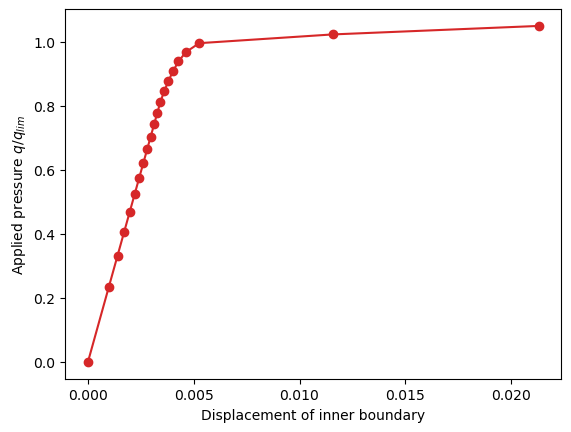

In [15]:
if len(bottom_inside_dof) > 0:  # test if proc has dof
    plt.plot(results[:, 0], results[:, 1], "-oC3")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.show()

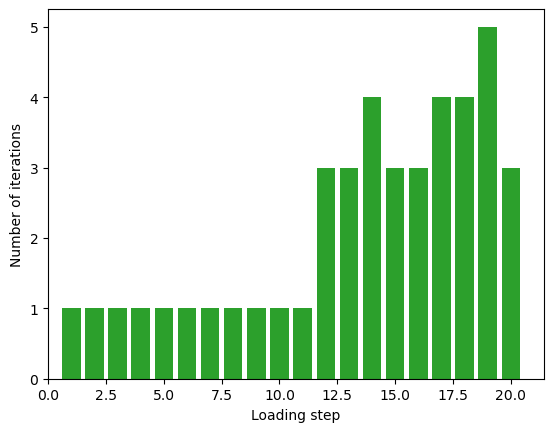

In [16]:
if len(bottom_inside_dof) > 0:
    plt.bar(np.arange(Nincr + 1), results[:, 2], color="C2")
    plt.xlabel("Loading step")
    plt.ylabel("Number of iterations")
    plt.xlim(0)
    plt.show()

In [17]:
# You can skip this if pandas is already installed in fenics environment
# Needed for hp-refinement study code block
!pip install pandas

### hp-Refinement Study
We implement a study of the effects of both **h-refinement** (mesh density) and **p-refinement** (polynomial degree of basis functions) on simulation accuracy and cost.

The function `run_elastoplastic_simulation(h, p)` encapsulates the full solve process. It regenerates the mesh and function space for each combination of parameters, then returns key metrics including:
- Maximum displacement magnitude (`u_max`)
- Runtime (if measured)
- Mesh element count

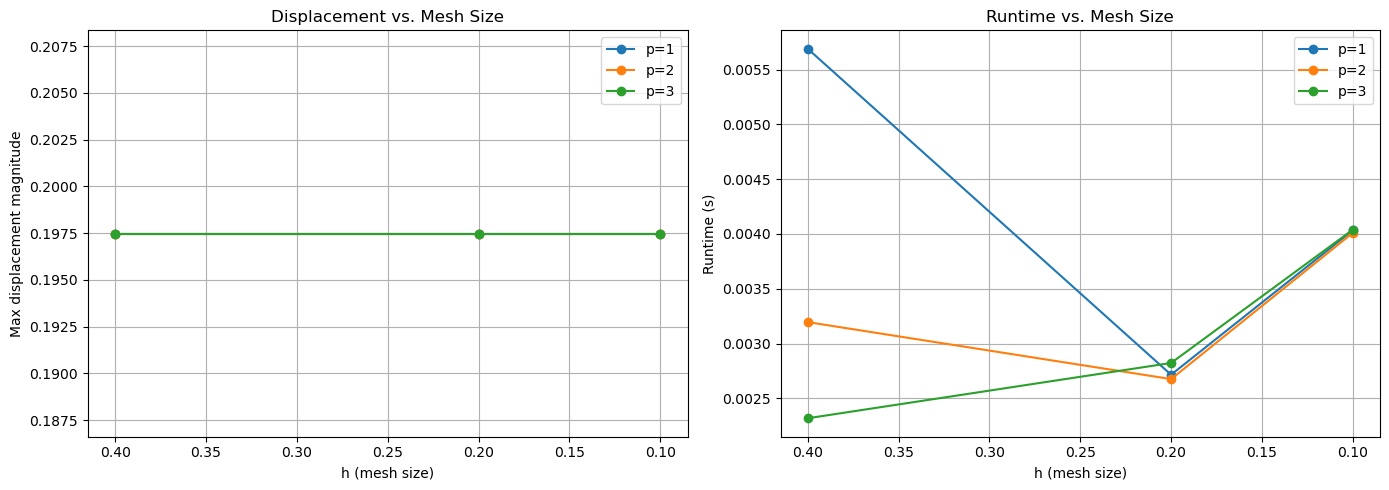

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define parameter grid
h_vals = [0.4, 0.2, 0.1]
p_vals = [1, 2, 3]

# Store results
results = []

for h in h_vals:
    for p in p_vals:
        try:
            result = run_elastoplastic_simulation(h, p)
            results.append(result)
        except Exception as e:
            print(f"Skipping h={h}, p={p} due to error: {e}")

# If no results, exit early
if not results:
    print("No successful simulations to plot.")
else:
    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Plot: Newton iterations or compute time vs mesh size for each p
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot u_max
    for p in df['deg_u'].unique():
        subset = df[df['deg_u'] == p]
        ax[0].plot(subset['hsize'], subset['u_max'], label=f'p={p}', marker='o')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('h (mesh size)')
    ax[0].set_ylabel('Max displacement magnitude')
    ax[0].set_title('Displacement vs. Mesh Size')
    ax[0].legend()
    ax[0].grid(True)

    # Plot runtime
    for p in df['deg_u'].unique():
        subset = df[df['deg_u'] == p]
        ax[1].plot(subset['hsize'], subset['time'], label=f'p={p}', marker='o')
    ax[1].invert_xaxis()
    ax[1].set_xlabel('h (mesh size)')
    ax[1].set_ylabel('Runtime (s)')
    ax[1].set_title('Runtime vs. Mesh Size')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()
